Importing necessary libraries and Dependencies

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os

Setup and Image Loading

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

imsize = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_path):
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("style.jpg")
content_img = image_loader("content.jpg")

assert style_img.size() == content_img.size(), "Style and Content image must be the same size"

Using device: cpu


Image Display and Saving Functions

In [68]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    if title: print(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def save_image(tensor, path="output.png"):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    image.save(path)

Loss Classes for Content and Style

In [69]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

VGG-19 Network and Normalization Layer

In [70]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Construction with Style and Content Layers

In [71]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]
    return model, style_losses, content_losses

Style Transfer Training Loop

In [72]:
input_img = content_img.clone()
style_weight = 1e8
content_weight = 1e3

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300):
    print("Building the style transfer model..")
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                                                      style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("Optimizing..")
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()

            if run[0] % 50 == 0:
                print(f"Step {run[0]}:")
                print(f"  Style Loss: {style_score.item():.4f}")
                print(f"  Content Loss: {content_score.item():.4f}")
                print(f"  Total Loss: {loss.item():.4f}\n")

            run[0] += 1
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

Run Style Transfer and Save Stylized Output

In [73]:
output_img = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

save_image(output, "stylized_output.jpg")
print("Stylized image saved as 'stylized_output.jpg'")

Building the style transfer model..
Optimizing..
Step 0:
  Style Loss: 0.0104
  Content Loss: 0.0000
  Total Loss: 1041372.5625

Step 50:
  Style Loss: 0.0003
  Content Loss: 15.1033
  Total Loss: 41188.8594

Step 100:
  Style Loss: 0.0001
  Content Loss: 13.2980
  Total Loss: 22643.6797

Step 150:
  Style Loss: 0.0001
  Content Loss: 12.3217
  Total Loss: 17466.1953

Step 200:
  Style Loss: 0.0000
  Content Loss: 12.0360
  Total Loss: 15479.6699

Step 250:
  Style Loss: 0.0000
  Content Loss: 11.9149
  Total Loss: 14761.6309

Step 300:
  Style Loss: 0.0000
  Content Loss: 11.9758
  Total Loss: 14187.5957

Stylized image saved as 'stylized_output.jpg'


Display

Content Image


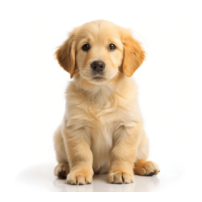

Style Image


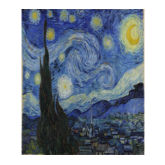

Output Image


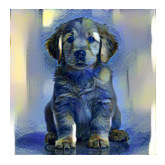

<Figure size 640x480 with 0 Axes>

In [74]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 3, 1)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 2)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 3)
imshow(output_img, title='Output Image')


plt.tight_layout()
plt.show()